# Preprocessing of the single-cell gene expression data set

This notebook summarizes the preprocessing of the single-cell gene expression data set used in the Image2Reg pipeline.

---

## 0. Environmental setup

In [9]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import mygene
import copy

import matplotlib.pyplot as plt

---

## 1. Read in data

The used gene expression data set consists of 1,152 U2OS FUCCI cells that were sorted by FACS and sequenced at single-cell resolution using SMART-seq2 chemistry. In total 42'728 genes were captured. We first read in the data.

In [10]:
fucci_adata = sc.read_csv(
    "../../../../data/resources/gex/scrnaseq/GSE146773_Counts.csv"
)
fucci_adata

AnnData object with n_obs × n_vars = 1152 × 42728

Before we can continue we need to translate the Ensemble IDs to their respective gene names for consistency purposes.

In [11]:
mg = mygene.MyGeneInfo()
fucci_gene_list = list(fucci_adata.var.index)
fucci_query_results = mg.querymany(
    fucci_gene_list, scopes="ensembl.gene", fields="symbol", species="human"
)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

We then filter out genes with duplicate or missing HGNC symbols.

In [12]:
fucci_gene_symbs = []
fucci_gene_ensid = []
missing_duplicate_symbs = []
for query_result in fucci_query_results:
    try:
        gene_symbol = query_result["symbol"]
        if gene_symbol not in fucci_gene_symbs:
            fucci_gene_symbs.append(query_result["symbol"])
            fucci_gene_ensid.append(query_result["query"])
        else:
            missing_duplicate_symbs.append(query_result["query"])
    except KeyError:
        missing_duplicate_symbs.append(query_result["query"])
len(missing_duplicate_symbs)

7469

There are 6803 ensemble ID that were not found in the reference data set and an additional of 1205 ensemble IDs mapped to the same HGNC symbol. We will remove the 6803 missing genes from our analyses and only keep the data from the first mapping for those cases where multiple ensemble IDs mapped to the same HGNC symbol.

In [13]:
fucci_adata = fucci_adata[:, fucci_gene_ensid]
fucci_adata

View of AnnData object with n_obs × n_vars = 1152 × 35938

In [14]:
fucci_adata.var["gene_symbol"] = fucci_gene_symbs

Trying to set attribute `.var` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
fucci_adata.var["ens_ids"] = fucci_adata.var_names

In [18]:
fucci_adata.var_names = fucci_gene_symbs

We are left with 34'720 genes.

---

## 2. Preprocessing

We will now run a standard single-cell gene expression data preprocessing pipeline that includes filtering out cells and genes with low support in the data set, library normalization and log-transformation.

In [20]:
fucci_adata.var["n_cells_per_gene"] = np.sum(
    (np.array(fucci_adata.to_df()) > 0), axis=0
)
fucci_adata.obs["n_genes_per_cell"] = np.sum(
    (np.array(fucci_adata.to_df())) > 0, axis=1
)

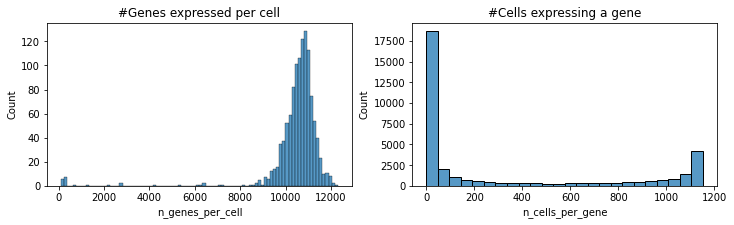

In [21]:
fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax = ax.flatten()
sns.histplot(fucci_adata.obs["n_genes_per_cell"], ax=ax[0])
ax[0].set_title("#Genes expressed per cell")

sns.histplot(fucci_adata.var["n_cells_per_gene"], ax=ax[1])
ax[1].set_title("#Cells expressing a gene")
plt.show()

We filter out cells for which not at least transcripts from 8'000 different genes were measured and genes that are expressed in less than 10 cells. The cut-offs were chosen under consideration of the corresponding empirical distributions to remove outlier.

In [22]:
sc.pp.filter_cells(fucci_adata, min_genes=8000)
sc.pp.filter_genes(fucci_adata, min_cells=10)
fucci_adata

AnnData object with n_obs × n_vars = 1126 × 21982
    obs: 'n_genes_per_cell', 'n_genes'
    var: 'gene_symbol', 'ens_ids', 'n_cells_per_gene', 'n_cells'

This filtering step reduces the dimensionality of the data set to 1'126 cells for which 21'445 genes were measured.

In [23]:
sc.pp.normalize_total(fucci_adata, target_sum=1e6)
sc.pp.log1p(fucci_adata)

---

## 3. Data export

We finally export the preprocessed gene expression data.

Finally, we save the two analyzed data sets and the gene target list to disk.

In [24]:
os.makedirs("../../../../data/experiments/rohban/gex/scrnaseq", exist_ok=True)
fucci_adata_fname = "../../../../data/experiments/rohban/gex/scrnaseq/fucci_adata.h5"
fucci_adata.write(fucci_adata_fname)

/home/paysan_d/miniconda3/envs/i2r/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ens_ids' as categorical
